In [11]:
import os
from DNASkittleUtils.DDVUtils import pp
import csv
from collections import defaultdict
from csv import DictReader, DictWriter
from pandas import read_csv
from itertools import chain
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def first(iterable):
    if isinstance(iterable, dict):
        return next(iter(iterable.items()))
    return next(iter(iterable))

In [3]:
liz = read_csv("GOenrich_db/lizzy_ash_ks.csv", sep='\t')
liz = liz[liz['Ks'] < 20]  # remove a couple bad values

wgd_recent = (liz['Ks'] > 0.16) & (liz['Ks'] < 0.38)
wgd_old = (liz['Ks'] > 0.5) & (liz['Ks'] < 0.8)
recent_duplication = liz['Ks'] < 0.2
unaffected =  ~wgd_old & ~recent_duplication  # ~wgd_recent &
affected = wgd_recent | wgd_old #| recent_duplication
len(liz[unaffected]), len(affected)
pp(len(liz[wgd_recent]) / len(liz))

'35.772825%'

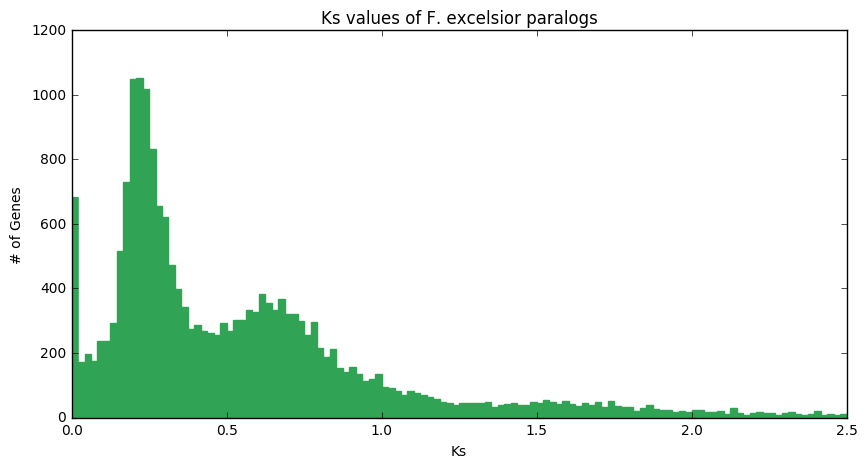

In [4]:

h = liz[liz['Ks'] < 2.5]['Ks'].hist(bins=120, figsize=(10,5), facecolor='#31a354', edgecolor='#31a354')
h.grid(False)
# h.linewidth(0)
h.set_xlabel('Ks')
h.set_ylabel('# of Genes')
h.set_title('Ks values of F. excelsior paralogs')

# 4.2.1 Extracting Homeologs from Duplications.csv

In [5]:
def collect_all_Nx_duplicated_genes(rows, Nx_counts, node_name):
    """Accepts a DataFrame, node_counts, Read in a table and split it into the gene names we want.  Identifies the node name.
    Uses pandas filtering to improve speed."""
    any_N1_duplicates = [k for k,v in Nx_counts.items() if v == 1]  # only accept single duplication events
    split_families = {}  # could be output as files
    for fam_id in any_N1_duplicates:
        focus = rows[(rows['Orthogroup'] == fam_id) & (rows['Species Tree Node'] == node_name)]
        row = next(focus.iterrows())[1]
        og = row['Orthogroup']
        # stripping off "OG" and starting with either 1=left or 2=right subtree
        split_families['1' + og[2:]] = row['Genes 1'].split(', ')
        split_families['2' + og[2:]] = row['Genes 2'].split(', ')
    print(len(split_families), "subtrees")
    return split_families


In [6]:
import os
from collections import defaultdict
from pandas import read_csv
def complete_homeolog_filtering(duplications_path, node_name):
    """Given a path to an OrthoFinder Duplications.csv and a species node name, it returns the list
    of gene names for Homeologs created in the WGD under that species node with only one duplication event.
    Return type is a list of pairs of split subtrees where each subtree is a list of gene names."""
    rows = read_csv(duplications_path, delimiter='\t')
    N_counts = defaultdict(lambda: 0)
    for index, line in rows[rows['Species Tree Node'] == node_name].iterrows():
        N_counts[line['Orthogroup']] += 1
    #Now that we've collected all the counts, for the node of interest, we can check which are exactly 1
    qualified_ogs = [og for og, count in N_counts.items() if count == 1]
    #we take only the rows (gene tree nodes) with qualified ogs and the mentioned node_name
    return collect_all_Nx_duplicated_genes(rows, N_counts, node_name)
    

In [7]:
Feb08 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\New_Analysis_From_Trees_Feb08\Duplications.csv"
Feb08_splits = complete_homeolog_filtering(Feb08, 'N2')

8152 subtrees


In [9]:
Feb08_splits['20008168']

['FRAX20_FRAX20_000014660.1_R0',
 'FRAX19_FRAX19_000014660.1_R0',
 'FRAX14_FRAX14_000014660.1_R0',
 'FRAX13_FRAX13_000014660.1_R0',
 'FRAX34_FRAX34_000014660.1_R0',
 'FRAX09_FRAX09_000014660.1_R0',
 'FRAX26_FRAX26_000014660.1_R0',
 'FRAX03_FRAX03_000014660.1_R0',
 'FRAX05_FRAX05_000014660.1_R0',
 'FRAX33_FRAX33_000014660.1_R0',
 'FRAX25_FRAX25_000014660.1_R0',
 'FRAX23_FRAX23_000014660.1_R0',
 'FRAX16_FRAX16_000014660.1_R0',
 'FRAX01_FRAX01_000014660.1_R0',
 'FRAX00_FRAEX38873_v2_000014660.1',
 'FRAX02_FRAX02_000014660.1_R0',
 'FRAX29_FRAX29_000014660.1_R0',
 'FRAX32_FRAX32_000210860.3_R2',
 'FRAX12_FRAX12_000014660.1_R0',
 'FRAX08_FRAX08_000014660.1_R0',
 'FRAX07_FRAX07_000014660.1_R0',
 'FRAX28_FRAX28_000014660.1_R0',
 'FRAX30_FRAX30_000014660.1_R0']

### Create Gene List for Ks Validation in KsPlots.ipynb

In [16]:
def write_subtrees_to_split_gene_set(subtrees, filename):
    import csv
    with open(filename, 'w', newline='\n') as csvfile:
        out = csv.writer(csvfile, delimiter='\t',
                                quotechar='"', quoting=csv.QUOTE_MINIMAL)
#         out.writerow(['"Orthogroup Subtree"', "Genes"])
        for og, genes in subtrees.items():
            out.writerow([og] + genes)


        print("Wrote", len(subtrees), "rows")

write_subtrees_to_split_gene_set(Feb08_splits, '2020_Feb08_homeolog_gene_set.csv')

Wrote 8152 rows


## Create homeolog_counts.txt table per species for CAFE input

In [18]:
from pandas import DataFrame, Series
def format_table(split_families, convert_fam_id=False):
    def species_count_from_subtree(subtree):
        assert hasattr(subtree, '__iter__')
        sub_counts = defaultdict(lambda: 0)
        for gene in subtree:
            sub_counts[gene.split('_')[0]] += 1
        assert sum(sub_counts.values()) == len(subtree)
        return sub_counts
    data = {}
    for name, subfamily in split_families.items():
        sub_counts = species_count_from_subtree(subfamily)
        data[name] = sub_counts
    df = DataFrame.from_dict(data, orient='index', )
    df.fillna(value=0, inplace=True)
    df = df.astype(int)
    df.index.name = 'Desc'
    if convert_fam_id:
        df['Family ID'] = df.apply(lambda row: str(row.name)[-1:] + str(row.name)[2:-2], axis=1) # e.g. OG0000212_1 => 10000212
    else:
        df['Family ID'] = df.apply(lambda row: row.name, axis=1)

    column_order = ['Family ID'] + sorted('Oeuropea	FRAX08	FRAX05	FRAX25	FRAX14	FRAX15	FRAX32	FRAX21	FRAX33	FRAX26	FRAX16	FRAX03	FRAX07	FRAX23	FRAX31	FRAX09	FRAX19	FRAX12	FRAX29	FRAX01	FRAX00	FRAX13	FRAX20	FRAX30	FRAX27	FRAX04	FRAX11	FRAX28	FRAX06'.split('\t'))
#     column_order.remove('FRAX02')
#     column_order.remove('FRAX34')
    df = df[column_order]
    return df

In [19]:
df = format_table(Feb08_splits)
df.to_csv(r'2020_Feb08_homeolog_counts.txt', sep='\t')
df.head()

,Family ID,FRAX00,FRAX01,FRAX03,FRAX04,FRAX05,FRAX06,FRAX07,FRAX08,FRAX09,...,FRAX25,FRAX26,FRAX27,FRAX28,FRAX29,FRAX30,FRAX31,FRAX32,FRAX33,Oeuropea
Desc,,,,,,,,,,,,,,,,,,,,,
10000013,10000013,1,1,1,1,1,2,2,1,1,...,1,0,1,1,2,2,1,1,2,1
10000057,10000057,1,1,0,0,0,1,0,1,0,...,0,1,1,0,1,0,0,1,1,1
10000069,10000069,2,6,9,8,9,6,10,8,9,...,9,8,9,9,8,11,9,8,9,1
10000138,10000138,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
10000193,10000193,0,1,1,2,2,1,1,0,1,...,1,1,2,2,2,1,2,2,1,1


# Everything that follows is the more complicated exploration that led to the simplified code in 4.2.1

# Gene Tree Accounting with Duplications.csv

In [4]:
from collections import defaultdict
def Nx_counts_from_Duplications(dup_path, node_name, n_events=1):
    Nx_counts = defaultdict(lambda: 0)
    from csv import DictReader
    orthogroups_seen = set()
    with open(dup_path,'r') as infile:
        lines = DictReader(infile, delimiter='\t')
#         print(lines.fieldnames)
        for line in lines:
            orthogroups_seen.add(line['Orthogroup'])
            if line['Species Tree Node'] == node_name:  # count mentions of N1
                Nx_counts[line['Orthogroup']] += 1
    return Nx_counts, orthogroups_seen

In [5]:
def heights(N1_counts):
    N1_heights = []
    for i in range(1, 10):
        N1_heights.append(len([og for og, c in N1_counts.items() if c == i]))
        print(i,       len([og for og, c in N1_counts.items() if c == i]))
    print('All', len(N1_counts))
    return N1_heights

------------

In [7]:
from math import log
def plot_dup_hist(N1_heights):
    fig, ax = plt.subplots()
    ax.bar([1,2,3,4,5,6,7,8,9], N1_heights, width=1, color='#3182bd')
    ax.set_title("Duplications at the Oleaceae Root per Orthogroup")
    ax.set_xlabel("Duplications")
    ax.set_ylabel("Families")

In [8]:
def plot_log_duplications(N1_heights):
    fig, ax = plt.subplots()
    ax.plot([1,2,3,4,5,6,7,8,9], [log(h) for h in N1_heights], 's-', color='#e6550d')
    ax.set_title("Log Duplications at the Oleaceae Root per Orthogroup")
    ax.set_xlabel("Duplications")
    ax.set_ylabel("Families (Natural Log)")

In [9]:
def print_ratios(N1_heights):
    ratios = []
    for i, h in enumerate(N1_heights):
        if i:
            print(round(h / N1_heights[i-1] , 2))
            ratios.append(h / N1_heights[i-1])
            if not h:
                break
    import statistics
    print("Mean:", statistics.mean(ratios[:5]))
    print("Std dev:", statistics.pstdev(ratios[:8]))
    print("Sum", sum([h for h in N1_heights]))

In [10]:
def report_graphs_duplications_selection(node_counts, my_orthogroups):    
    N1_heights = heights(node_counts)
    plot_dup_hist(N1_heights)
    plot_log_duplications(N1_heights)
    print_ratios(N1_heights)
    old_study = [og for og, c in node_counts.items() if c == 1]
    print("Total Orthogroups Found Containing the Target Duplication", len(old_study))

In [6]:
N1_counts, ortho_Jul04 = Nx_counts_from_Duplications("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv", 'N1')

1 4242
2 2377
3 1256
4 680
5 350
6 194
7 125
8 85
9 57
All 9546
0.56
0.53
0.54
0.51
0.55
0.64
0.68
0.67
Mean: 0.5398277803614446
Std dev: 0.06269242664855937
Sum 9366
Total Orthogroups Found Containing the Target Duplication 4242


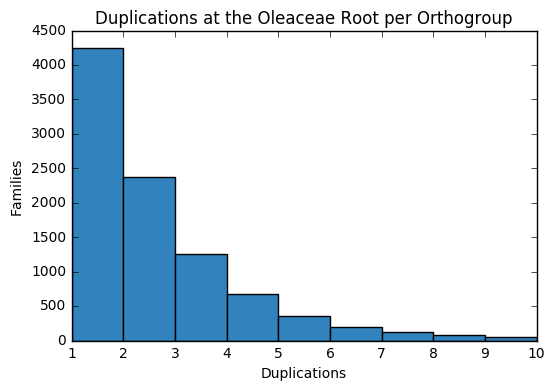

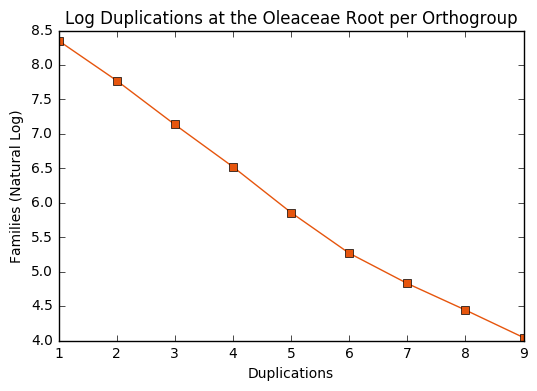

In [11]:
report_graphs_duplications_selection(N1_counts, ortho_Jul04)

**Conclusion:** Still needs more thought.  Each extra step, between 0 and 1 duplication events to make the ratios line up for the first one:  Half of genes are duplicable.  Half of those actually get duplicated.  Half of those have N+1 duplications and so on.  Ratio might be different if we included the x > N tail instead of just the height of one bar.  CMF vs PDF essentially.  

**Conclusion** That is eerily close to a perfectly straight line on the log scale.  The chance of seeing N+1 duplication events is a percentage of the previous number.

**Conclusion** 85% of OGs with a duplication have an internal duplication.  49.9% of them mention N1.  22% have one duplication there, 2377+4242 = 34% of them have 1 or 2 duplications at N1.  There's still twice as many with 1 than 2.  I would need Jasmine to separate the two categories.  

1 4076
2 2363
3 1246
4 678
5 338
6 202
7 129
8 89
9 55
All 9356
0.58
0.53
0.54
0.5
0.6
0.64
0.69
0.62
Mean: 0.5494660613210605
Std dev: 0.058748587666901775
Sum 9176
Total Orthogroups Found Containing the Target Duplication 4076


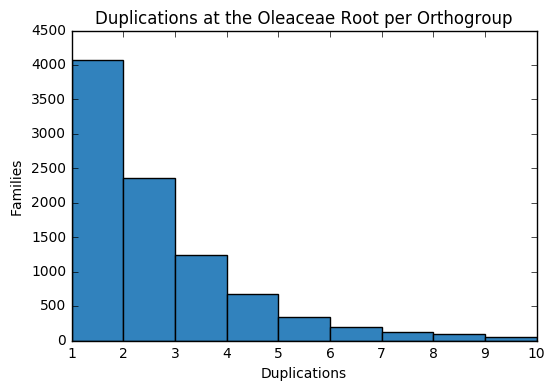

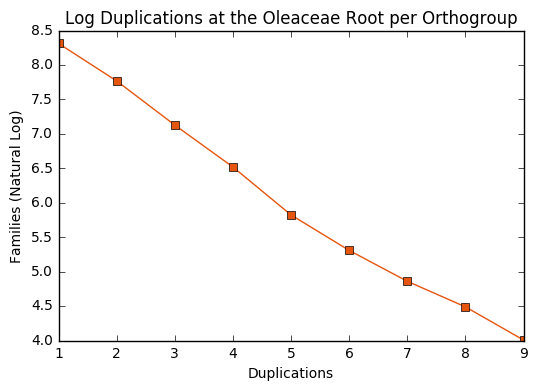

In [12]:
Feb08 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\New_Analysis_From_Trees_Feb08\Duplications.csv"
N2_counts, ortho_Feb08 = Nx_counts_from_Duplications(Feb08, 'N2')
report_graphs_duplications_selection(N2_counts, ortho_Feb08)

# Separate out Study Homeologs into pairs of trees

*Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Recon_Gene_Trees\212_count_scrap.tre*  
A vs B subtrees after a duplication are defined in the "Genes 1" and "Genes 2" columns of Duplications.csv. The "Gene Tree Node" seems nonsensical, but the number and names of listed genes correspond to actual subtrees.

from shutil import copy
import os
from os.path import splitext, basename
os.chdir(r'D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Orthologues_Jul04_2')

##### Rename every text file to a .tre file
from glob import glob
for f in glob('Gene_Trees/*.txt'):
    os.rename(f, 'Gene_trees/'+splitext(basename(f))[0]+'.tre')
    
for f in glob('Recon_Gene_Trees/*.txt'):
    os.rename(f, 'Recon_Gene_trees/'+splitext(basename(f))[0]+'.tre')

## Splitting into pairs of sets of genes following the WGD

In [14]:
import os
from collections import defaultdict
from pandas import read_csv
def duplications_count_by_node(species_node, dup_path, rows):
    N_counts = defaultdict(lambda: 0)
    os.chdir(r'D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications')
    for index, line in rows[rows['Species Tree Node'] == species_node].iterrows():
        og = line['Orthogroup']
        N_counts[og] += 1
    study_homeologs = set([og for og, c in N_counts.items() if c == 1])
    

    all_splits = collect_all_Nx_duplicated_genes(rows, N_counts, species_node)
    print('Found', len([k for k,v in N_counts.items() if v > 0])*2, 'subtrees')
    print('Using', len(study_homeologs)*2, 'subtrees')
    return study_homeologs, N_counts, all_splits



In [16]:
def split_subtrees(target_species_node, duplications_path):
    """There's a crucial difference between the returned study_homeologs and split_families.
    split_families is NOT filtered to only be 1 duplication at the target node. It can be 
    any number of duplications.  study_homeologs is filtered to == 1."""
    rows = read_csv(duplications_path, delimiter='\t')
    study_homeologs, N_counts, all_splits = duplications_count_by_node(target_species_node, duplications_path, rows)
    split_families = {}
    
    #all_splits_table = format_table(all_splits)
    #all_splits_table.head()
    #all_splits_table.to_csv(r'CAFE-4.2\data\corrected_orthologs\all_N1_duplication_counts.csv', sep='\t')
    study_rows = rows[rows['Orthogroup'].isin(study_homeologs) & (rows['Species Tree Node'] == target_species_node)]
    def final_split():
        for index, row in study_rows.iterrows():
            og = row['Orthogroup']
            split_families[og + '_1'] = row['Genes 1'].split(', ')
            split_families[og + '_2'] = row['Genes 2'].split(', ')
    print(pp(sum([len(v) for v in split_families.values()])), 
          "Total Genes included in the study, separated over", 
          pp(len(split_families)), "gene families")
    return study_homeologs, N_counts, split_families

Feb08 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\New_Analysis_From_Trees_Feb08\Duplications.csv"
Feb08_homeologs, N2_counts, subtrees_Feb08 = split_subtrees('N2', Feb08)

18712 subtrees
Found 18712 subtrees
Using 8152 subtrees
0 Total Genes included in the study, separated over 0 gene families


In [17]:
Jul04 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv"
Jul04_homeologs, N1_counts, subtrees_Jul04 = split_subtrees('N1', Jul04)

19092 subtrees
Found 19092 subtrees
Using 8484 subtrees
0 Total Genes included in the study, separated over 0 gene families


96,778 Total Genes included in the study, separated over 3,204 gene families


In [17]:
#TODO Double check with original Jul04 dataset to see if we still get 8484 families
#N1_counts, orthogroups_seen = Nx_counts_from_Duplications("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv", 'N1')

Peel off first part of gene name for species count

In [59]:
gene_set = set()
gene_set.update(*(v for v in split_families.values()))
len(gene_set)

96778

In [60]:
unique_starts = set(gene.split('_')[0] for gene in gene_set)
unique_starts

{'FRAX00',
 'FRAX01',
 'FRAX02',
 'FRAX03',
 'FRAX04',
 'FRAX05',
 'FRAX06',
 'FRAX07',
 'FRAX08',
 'FRAX09',
 'FRAX11',
 'FRAX12',
 'FRAX13',
 'FRAX14',
 'FRAX15',
 'FRAX16',
 'FRAX19',
 'FRAX20',
 'FRAX21',
 'FRAX23',
 'FRAX25',
 'FRAX26',
 'FRAX27',
 'FRAX28',
 'FRAX29',
 'FRAX30',
 'FRAX31',
 'FRAX32',
 'FRAX33',
 'FRAX34',
 'Oeuropea'}

In [61]:
[gene for gene in gene_set if not gene.startswith('FRAX') and not gene.startswith('Oeuropea')]

[]

**Conclusion:** There are no Solanum or Erythranthe genes in these subtrees.  That was probably an implicit criteria of their selection.  Is this a problem?  Since I'm retaining the original OG names, we can always cross reference the included subtrees and the excluded subtrees (which would contain Solanum and Erythranthe).

*TODO: Pull OG out of Orthogroups.csv and remove the genes listed in "Genes 1" and "Genes 2" (also in gene_set) and save this as OG#####_out.*

In [62]:
df = format_table(split_families).head()

df.to_csv(r'CAFE-4.2\data\homeologs_only\homeolog_counts.txt', sep='\t')

In [63]:
df.head()

,Family ID,FRAX00,FRAX01,FRAX03,FRAX04,FRAX05,FRAX06,FRAX07,FRAX08,FRAX09,...,FRAX25,FRAX26,FRAX27,FRAX28,FRAX29,FRAX30,FRAX31,FRAX32,FRAX33,Oeuropea
Desc,,,,,,,,,,,,,,,,,,,,,
OG0000013_1,OG0000013_1,1,1,1,1,1,2,2,1,1,...,1,0,1,1,2,2,1,1,2,1
OG0000013_2,OG0000013_2,3,3,1,1,2,2,1,1,2,...,2,2,1,1,1,1,2,1,1,0
OG0000057_1,OG0000057_1,1,1,0,0,0,1,0,1,0,...,0,1,1,0,1,0,0,1,1,1
OG0000057_2,OG0000057_2,2,11,8,8,10,6,9,8,10,...,2,6,9,12,10,10,1,11,6,0
OG0000069_1,OG0000069_1,2,6,9,8,9,6,10,8,9,...,9,8,9,9,8,11,9,8,9,1



# Feb 05 Analysis Using Corrected Outgroup Reconciled Gene Trees

Previous studies were done with Orthogroups made with all species (FRAX02 and FRAX34) but also the wrong relationship between Solanum and Mimmulus (Eryanthre).  Having corrected that, the species tree that gene trees are reconciled to also need to be updated.  
* The node might not be called N1 anymore
    * Based on the labeling of nodes from the same program I expect **the species tree Oleaceae to be N2**
* We should still filter for 1 split at the WGD per gene tree
* Still take the left and right subtrees and discard the rest of the gene tree outside those two subtrees.  That ensure we're comparing gene pairs of equal age from the same event.  
* Technically every pairwise combination across (but not within) the two subtrees should be a valid Ks and 4DTv


In [64]:
Feb05 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\New_Analysis_From_Trees_Feb05\Duplications.csv"
N2_counts, orthogroups_N2_seen = Nx_counts_from_Duplications(Feb05, node_name='N2')

In [65]:
dups_df = read_csv(Feb05, delimiter='\t')

In [66]:
dups_df[dups_df['Orthogroup'] == 'OG0003492'].head()

,Orthogroup,Species Tree Node,Gene Tree Node,Support,Type,Genes 1,Genes 2
45502,OG0003492,N0,n0,0.060606,Shared,"Slycopersicum_Solyc05g055020.2.1, Slycopersicu...","Slycopersicum_Solyc06g082210.1.1, Oeuropea_OE6..."
45503,OG0003492,Slycopersicum,n2,1.000000,Terminal,Slycopersicum_Solyc05g055020.2.1,Slycopersicum_Solyc04g009980.2.1
45504,OG0003492,N2,n5,1.000000,Shared,"Oeuropea_OE6A096146P1, FRAX08_FRAX08_000398260...","Oeuropea_OE6A064601P1, Oeuropea_OE6A088529P1, ..."
45505,OG0003492,Oeuropea,n39,1.000000,Terminal,Oeuropea_OE6A064601P1,Oeuropea_OE6A088529P1
45506,OG0003492,Mguttatus,n69,1.000000,Terminal,Mguttatus_Migut.H01303.1.p,Mguttatus_Migut.D00854.1.p


In [67]:
N1_counts['OG0003492']

1

In [38]:
from statistics import mean
N2_compare = [N2_counts[og] for og in Jul04_homeologs]
mean(N2_compare)

0.3941537010843942

In [39]:
N0_counts, ignored = Nx_counts_from_Duplications(Feb05, node_name='N0')
mean([N0_counts[og] for og in Jul04_homeologs])

0.09288071664309289

In [40]:
Nx_counts, ignored = Nx_counts_from_Duplications(Feb05, node_name='N1')
mean([Nx_counts[og] for og in Jul04_homeologs])

0.08557284299858557

In [41]:
Nx_counts, ignored = Nx_counts_from_Duplications(Feb05, node_name='N2')
mean([Nx_counts[og] for og in Jul04_homeologs])

0.3941537010843942

In [42]:
N3_counts, ignored = Nx_counts_from_Duplications(Feb05, node_name='N3')
mean([N3_counts[og] for og in Jul04_homeologs])

0.33097595473833097

In [43]:
N4_counts, ignored = Nx_counts_from_Duplications(Feb05, node_name='N4')
mean([N4_counts[og] for og in Jul04_homeologs])

0.32814710042432815

**GOAL:** Test to what degree N1_counts and N2_counts differ.  
* Given a group of N1_counts that are all 1, their average in N2 counts should be close to 1.
* Given a different Species tree node, the results should be more divergent than 3%

| Results | Average |
| ----------- | ----------- |
| N0    | 0.11621876473361623 |
| N1    | 0.11291843470061291  |
| **N2** | **0.9707685054219708**  |
| N3    | 0.5044790193305044|
| N4    | 0.4941065535124941|

* Results strongly support that N2 is the species node and that results are largely unchanged ~3%

-------------------------------
### Test for overlap in OG names

In [77]:
study_homeologs = set(study_homeologs)
len(study_homeologs) # from incorrect species tree

1616

In [78]:
refined_ohnologs = {og for og in N2_counts if N2_counts[og] == 1}
len(refined_ohnologs), pp(len(refined_ohnologs) / len(study_homeologs))

(1616, '100.000000%')

In [75]:
len(refined_ohnologs.intersection(study_homeologs)) / 4075  # Agreement overlap

0.39656441717791413

In [79]:
len(refined_ohnologs.difference(study_homeologs)) / 4075

0.0

#### Conclusion: 97% overlap means the difference would be negligible
-------------------------------
### Test if the same gene Names would have been used in left-right subtrees for Ohnologs

In [21]:
def gene_set_from_Duplications_csv(path, node_name):
    counts, ignored = Nx_counts_from_Duplications(path, node_name=node_name)
    print("Done collecting", len(counts), "counts")
    df = read_csv(path, delimiter='\t')
    splits = collect_all_Nx_duplicated_genes(df, counts, node_name)
    print("Identified", len(splits), "valid ohnolog tree splits")
    gene_set = set()
    for v in splits.values():
        gene_set.update(v)
    print(len(gene_set), "ohnolog genes identified")
    return gene_set, splits

In [22]:
Jul04 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv" 
Jul04_set, Jul04_splits = gene_set_from_Duplications_csv(Jul04, 'N1')

Done collecting 9546 counts
19092
Identified 19092 valid ohnolog tree splits
579487 ohnolog genes identified


In [25]:
revised_splits = collect_all_Nx_duplicated_genes(dups_df, N2_counts, 'N2')

NameError: name 'dups_df' is not defined

In [94]:
pp(len(Jul04_splits) / len(revised_splits))

'181.482890%'

In [24]:
#Virutally identical sets of keys
pp(len(set(revised_splits.keys()).intersection(Jul04_splits.keys())) / 18712)

NameError: name 'revised_splits' is not defined

#### Final conclusion: revised_gene_set with corrected outgroup species tree yields nearly identical results.  There's no need to change downstream analysis or doubt the membership of Ohnologs

## Testing Determinism of Gene Tree Reconciliation
corrected_homeologs.sh was run two more times, yielding Feb05, Feb08, and Feb12 that were all run under **exactly** the same parameters.  Differences in these results are due to non-determinism of the algorithm.

In [26]:
Jul04 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv" 
Jul04_set, Jul04_splits = gene_set_from_Duplications_csv(Jul04, 'N1')

Done collecting 9546 counts
19092
Identified 19092 valid ohnolog tree splits
579487 ohnolog genes identified


In [27]:
Feb05 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\New_Analysis_From_Trees_Feb05\Duplications.csv"
Feb05_set, Feb05_splits = gene_set_from_Duplications_csv(Feb05, 'N2')

Done collecting 5260 counts
10520
Identified 10520 valid ohnolog tree splits
396040 ohnolog genes identified


In [26]:
Feb08 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\New_Analysis_From_Trees_Feb08\Duplications.csv"
Feb08_set, Feb08_splits = gene_set_from_Duplications_csv(Feb08, 'N2')

Done collecting 9356 counts
18712 subtrees
Identified 18712 valid ohnolog tree splits
570551 ohnolog genes identified


In [22]:
Feb12 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\New_Analysis_From_Trees_Feb12\Duplications.csv"
Feb12_set, Feb12_splits = gene_set_from_Duplications_csv(Feb12, 'N2')

Done collecting 9357 counts
18714 subtrees
Identified 18714 valid ohnolog tree splits
570520 ohnolog genes identified


In [30]:
def overlap_geneset_statistics(setA, setB):
#     pp(len(all_splits) / len(revised_splits))
#     pp(len(set(revised_splits.keys()).intersection(all_splits.keys())) / 18712)
    longer = max(len(setB), len(setA))
    print("Lengths are", pp(min(len(setA), len(setB)) / longer), "of the longer one")
    print("Gene intersection is", pp( len(setA.intersection(setB))/ longer),"of the longer one")
overlap_geneset_statistics(Jul04_set, Feb05_set)

Lengths are 68.343207% of the longer one
Gene intersection is 66.984937% of the longer one


In [31]:
overlap_geneset_statistics(Feb08_set, Feb05_set)

Lengths are 69.413602% of the longer one
Gene intersection is 69.292666% of the longer one


In [32]:
overlap_geneset_statistics(Feb08_set, Feb12_set)

Lengths are 99.994567% of the longer one
Gene intersection is 99.913943% of the longer one


In [33]:
overlap_geneset_statistics(Feb05_set, Feb12_set)

Lengths are 69.417374% of the longer one
Gene intersection is 69.233331% of the longer one


In [34]:
overlap_geneset_statistics(Jul04_set, Feb08_set)

Lengths are 98.457946% of the longer one
Gene intersection is 96.995964% of the longer one


In [35]:
overlap_geneset_statistics(Jul04_set, Feb12_set)

Lengths are 98.452597% of the longer one
Gene intersection is 97.007526% of the longer one


**New Conclusion: Feb05 is the only outlier. The rest have 97% agreement. I suspect Feb05 file got changed / switched at some point.**

In [23]:
species_names = set()
for i, name in enumerate(Feb12_set):
    if i > 1000:
        break
    species_names.add(name[:6])
species_names

{'FRAX00',
 'FRAX01',
 'FRAX02',
 'FRAX03',
 'FRAX04',
 'FRAX05',
 'FRAX06',
 'FRAX07',
 'FRAX08',
 'FRAX09',
 'FRAX11',
 'FRAX12',
 'FRAX13',
 'FRAX14',
 'FRAX15',
 'FRAX16',
 'FRAX19',
 'FRAX20',
 'FRAX21',
 'FRAX23',
 'FRAX25',
 'FRAX26',
 'FRAX27',
 'FRAX28',
 'FRAX29',
 'FRAX30',
 'FRAX31',
 'FRAX32',
 'FRAX33',
 'FRAX34',
 'Oeurop'}

### Print gene list for Ks plots

# Dill Session Save / Load

##  Save a Notebook session:
import dill
dill.dump_session('Homeologs_Analysis.db')

Restore a Notebook session:
import dill
dill.load_session('Homeologs_Analysis.db')